# Recognizing Faces in an Image File

- img_path in the below contains the file name (with extension) as string variable.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from scipy import misc
import cv2
import numpy as np
from library import facenet
from library import detect_face
import os
import time
import pickle
import sys

img_path='example_02.jpg'
modeldir = './model/20191012-185253.pb'
classifier_filename = './class/classifier.pkl'
npy='./npy'
train_img="./raw_images"

with tf.Graph().as_default():
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    with sess.as_default():
        pnet, rnet, onet = detect_face.create_mtcnn(sess, npy)

        minsize = 20  # minimum size of face
        threshold = [0.6, 0.7, 0.7]  # three steps's threshold
        factor = 0.709  # scale factor
        margin = 44
        frame_interval = 3
        batch_size = 1000
        image_size = 182
        input_image_size = 160
        
        HumanNames = os.listdir(train_img)
        HumanNames.sort()

        print('Loading feature extraction model')
        facenet.load_model(modeldir)

        images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
        embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
        phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
        embedding_size = embeddings.get_shape()[1]


        classifier_filename_exp = os.path.expanduser(classifier_filename)
        with open(classifier_filename_exp, 'rb') as infile:
            (model, class_names) = pickle.load(infile)

        c = 0

        print('Start Recognition!')
        prevTime = 0
        # ret, frame = video_capture.read()
        frame = cv2.imread(img_path,0)

        frame = cv2.resize(frame, (0,0), fx=0.5, fy=0.5)    #resize frame (optional)

        curTime = time.time()+1    # calc fps
        timeF = frame_interval

        if (c % timeF == 0):
            find_results = []

            if frame.ndim == 2:
                frame = facenet.to_rgb(frame)
            frame = frame[:, :, 0:3]
            bounding_boxes, _ = detect_face.detect_face(frame, minsize, pnet, rnet, onet, threshold, factor)
            nrof_faces = bounding_boxes.shape[0]
            print('Face Detected: %d' % nrof_faces)

            if nrof_faces > 0:
                det = bounding_boxes[:, 0:4]
                img_size = np.asarray(frame.shape)[0:2]

                cropped = []
                scaled = []
                scaled_reshape = []
                bb = np.zeros((nrof_faces,4), dtype=np.int32)

                for i in range(nrof_faces):
                    emb_array = np.zeros((1, embedding_size))

                    bb[i][0] = det[i][0]
                    bb[i][1] = det[i][1]
                    bb[i][2] = det[i][2]
                    bb[i][3] = det[i][3]

                    # inner exception
                    if bb[i][0] <= 0 or bb[i][1] <= 0 or bb[i][2] >= len(frame[0]) or bb[i][3] >= len(frame):
                        print('face is too close')
                        continue

                    cropped.append(frame[bb[i][1]:bb[i][3], bb[i][0]:bb[i][2], :])
                    cropped[i] = facenet.flip(cropped[i], False)
                    scaled.append(misc.imresize(cropped[i], (image_size, image_size), interp='bilinear'))
                    scaled[i] = cv2.resize(scaled[i], (input_image_size,input_image_size),
                                           interpolation=cv2.INTER_CUBIC)
                    scaled[i] = facenet.prewhiten(scaled[i])
                    scaled_reshape.append(scaled[i].reshape(-1,input_image_size,input_image_size,3))
                    feed_dict = {images_placeholder: scaled_reshape[i], phase_train_placeholder: False}
                    emb_array[0, :] = sess.run(embeddings, feed_dict=feed_dict)
                    predictions = model.predict_proba(emb_array)
                    print(predictions)
                    best_class_indices = np.argmax(predictions, axis=1)
                    # print(best_class_indices)
                    best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
                    print(best_class_probabilities)
                    cv2.rectangle(frame, (bb[i][0], bb[i][1]), (bb[i][2], bb[i][3]), (0, 255, 0), 2)    #boxing face

                    #plot result idx under box
                    text_x = bb[i][0]
                    text_y = bb[i][3] + 20
                    print('Result Indices: ', best_class_indices[0])
                    print(HumanNames)
                    for H_i in HumanNames:
                        # print(H_i)
                        if HumanNames[best_class_indices[0]] == H_i:
                            result_names = HumanNames[best_class_indices[0]]
                            cv2.putText(frame, result_names, (text_x, text_y), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                        1, (0, 0, 255), thickness=1, lineType=2)
            else:
                print('Unable to align')
        cv2.imshow('Image', frame)

        if cv2.waitKey(1000000) & 0xFF == ord('q'):
            sys.exit("Thanks")
        cv2.destroyAllWindows()

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Loading feature extraction model
Model filename: ./model/20191012-185253.pb
Start Recognition!
Face Detected: 8


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


[[0.93148507 0.00410725 0.02307723 0.01348702 0.01483855 0.01300488]]
[0.93148507]
Result Indices:  0
['Bill_Hader', 'Kate_McKinnon', 'bobby_moynihan', 'jason_sudeikis', 'kenan_thompson', 'kristen_wiig']
[[0.01583065 0.0090396  0.00755498 0.01810251 0.93587521 0.01359705]]
[0.93587521]
Result Indices:  4
['Bill_Hader', 'Kate_McKinnon', 'bobby_moynihan', 'jason_sudeikis', 'kenan_thompson', 'kristen_wiig']
[[0.00696434 0.91804383 0.01951049 0.00964366 0.00926138 0.03657631]]
[0.91804383]
Result Indices:  1
['Bill_Hader', 'Kate_McKinnon', 'bobby_moynihan', 'jason_sudeikis', 'kenan_thompson', 'kristen_wiig']
[[0.01651643 0.00474048 0.93157867 0.01528214 0.01322391 0.01865837]]
[0.93157867]
Result Indices:  2
['Bill_Hader', 'Kate_McKinnon', 'bobby_moynihan', 'jason_sudeikis', 'kenan_thompson', 'kristen_wiig']
[[0.01111831 0.0056454  0.03057239 0.93045618 0.01390764 0.00830008]]
[0.93045618]
Result Indices:  3
['Bill_Hader', 'Kate_McKinnon', 'bobby_moynihan', 'jason_sudeikis', 'kenan_thompso

SystemExit: Thanks

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Output:

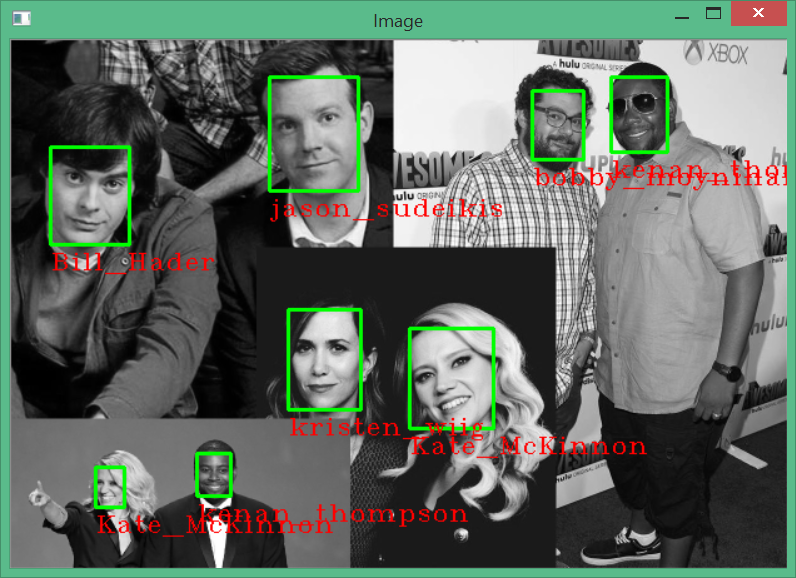